## Prerequisites

In [1]:
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils.data_utils import load_dataset ,load_file, split_ids
from utils.preprocessing import create_batch_sequences
from models.models import build_model
from models.losses import MyWeightedBinaryCrossentropy, MyWeightedMeanSquaredError
from utils.evaluate import compare_events
from scipy.signal import find_peaks
np.random.seed(123)

For each valid trial, the relevant data and information are saved in **five** different data files:
- sub-\<label\>_task-\<label\>[_run-\<label\>]_events.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-imu_channels.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-imu_motion.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-omc_channels.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-omc_motion.tsv

As we only consinder **walk** trials, we can look for any **_events.tsv** file that contains **_task-walk** in the filename.

## Get data

In [2]:
# Set root directory
ROOT_DIR = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata" if sys.platform == "linux" else "Z:\\Keep Control\\Data\\lab dataset\\rawdata"

# Split subjects into a train, validation, and test set
train_ids, val_ids, test_ids = split_ids(ROOT_DIR, by=["gender", "participant_type"])

In [3]:
# User settings
TRACKED_POINTS = ["left_ankle", "right_ankle", "left_shank", "right_shank"]
INCL_MAGN = False
NORMALIZE = True

In [4]:
# Get datasets
ds_train = load_dataset(ROOT_DIR, sub_ids=train_ids, tracked_points=TRACKED_POINTS, incl_magn=INCL_MAGN, normalize=NORMALIZE)
ds_val = load_dataset(ROOT_DIR, sub_ids=val_ids, tracked_points=TRACKED_POINTS, incl_magn=INCL_MAGN, normalize=NORMALIZE)
ds_test = load_dataset(ROOT_DIR, sub_ids=test_ids, tracked_points=TRACKED_POINTS, incl_magn=INCL_MAGN, normalize=NORMALIZE)

In [5]:
# Create batches of sequences for training and validation
WIN_LEN = 400
STEP_LEN = 200
train_data, train_targets, ds_train_batches = create_batch_sequences(ds_train, win_len=WIN_LEN, step_len=STEP_LEN)
val_data, val_targets, ds_val_batches = create_batch_sequences(ds_val, win_len=WIN_LEN, step_len=STEP_LEN)

## Build model

In [6]:
from tensorflow import keras
from tcn import TCN, tcn_full_summary

In [7]:
NB_FILTERS = 16
KERNEL_SIZE = 5
DILATIONS = [1, 2, 4]
PADDING = "same"

In [8]:
CALLBACKS = [
    keras.callbacks.EarlyStopping(patience=5, monitor="val_loss")
]

In [9]:
kwargs = {
    "nb_filters": NB_FILTERS,
    "kernel_size": KERNEL_SIZE,
    "dilations": DILATIONS,
    "padding": PADDING,
}

In [10]:
INPUT_DIM = train_data.shape[-1]
CLASS_NAMES = list(train_targets.keys())
# LOSS_FN = keras.losses.MeanSquaredError()
# LOSS_FN = MyWeightedMeanSquaredError(0.01)

In [11]:
model = build_model(
    input_dim=INPUT_DIM, 
    class_names=CLASS_NAMES, 
    loss_fn=MyWeightedMeanSquaredError(1/300), 
    **kwargs
)
model.summary()

Model: "tcn_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 6)]    0           []                               
                                                                                                  
 tcn_layer (TCN)                (None, None, 16)     7472        ['inputs[0][0]']                 
                                                                                                  
 initial_contact (Dense)        (None, None, 1)      17          ['tcn_layer[0][0]']              
                                                                                                  
 final_contact (Dense)          (None, None, 1)      17          ['tcn_layer[0][0]']              
                                                                                          

In [12]:
MAX_EPOCHS = 150

In [13]:
history = model.fit(
    x=train_data, 
    y=train_targets, 
    batch_size=16, 
    epochs=MAX_EPOCHS, 
    validation_data=(val_data, val_targets),
    shuffle=True,
    callbacks=CALLBACKS,
    verbose=1
)

Epoch 1/150
211/211 [==============================] - 6s 9ms/step - loss: 0.0131 - initial_contact_loss: 0.0038 - final_contact_loss: 0.0093 - val_loss: 0.0059 - val_initial_contact_loss: 0.0013 - val_final_contact_loss: 0.0046
Epoch 2/150
211/211 [==============================] - 2s 7ms/step - loss: 0.0021 - initial_contact_loss: 5.6950e-04 - final_contact_loss: 0.0015 - val_loss: 0.0014 - val_initial_contact_loss: 5.9629e-04 - val_final_contact_loss: 7.5460e-04
Epoch 3/150
211/211 [==============================] - 2s 7ms/step - loss: 9.7069e-04 - initial_contact_loss: 4.2673e-04 - final_contact_loss: 5.4396e-04 - val_loss: 0.0010 - val_initial_contact_loss: 4.7930e-04 - val_final_contact_loss: 5.5675e-04
Epoch 4/150
211/211 [==============================] - 2s 7ms/step - loss: 8.2457e-04 - initial_contact_loss: 3.7938e-04 - final_contact_loss: 4.4519e-04 - val_loss: 9.4055e-04 - val_initial_contact_loss: 4.4967e-04 - val_final_contact_loss: 4.9088e-04
Epoch 5/150
211/211 [=======

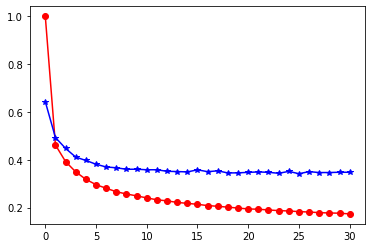

In [14]:
fig, ax = plt.subplots(1, 1)
ax.plot([history.history["loss"][i]/history.history["loss"][1] for i in range(1, len(history.history["loss"]))], 'ro-', label='training')
ax.plot([history.history["val_loss"][i]/history.history["loss"][1] for i in range(1, len(history.history["loss"]))], 'b*-', label="validation")
plt.show()

### Evaluate on test set

In [15]:
for ix_instance in range(len(ds_test)):
    ds_test[ix_instance]['predictions'] = model.predict(np.expand_dims(ds_test[ix_instance]['data'], axis=0))

In [41]:
df_out = {
    'sub_id': [],
    'filename_prefix': [],
    'tracked_point': [],
    'event_type': [],
    'ix_ref': [],
    'ix_pred': []
}
for ix_instance in range(len(ds_test)):
    # Filename prefix
    # print(f"{ds_test[ix_instance]['filename_prefix']:s} ... {ds_test[ix_instance]['tracked_point']:s}")
    
    # Initial contacts
    ix_targets_IC = np.argwhere(ds_test[ix_instance]['targets']['initial_contact']==1)[:,0]
    ix_predictions_IC, _ = find_peaks(ds_test[ix_instance]['predictions'][0][0][:,0], height=0.4, distance=200//4)
    targets_2_predictions, predictions_2_targets, _ = compare_events(ix_targets_IC, ix_predictions_IC, thr=25)
    # print(f"{'Map targets to preds':>22s}: {targets_2_predictions}")
    # print(f"{'Index of targets':>22s}: {ix_targets_IC}")
    # print(f"{'Index of preds':>22s}: {ix_predictions_IC}")
    # print(f"{'Map preds to targets':>22s}: {predictions_2_targets}")
    
    # Loop over the target ICs
    for i in range(len(ix_targets_IC)):
        # If this IC maps to a predicted event
        if targets_2_predictions[i] > -999:
            # Add the corresponding prediction to the list
            df_out['ix_pred'].append(ix_predictions_IC[targets_2_predictions[i]])
        else:
            df_out['ix_pred'].append(np.nan)
        df_out['ix_ref'].append(ix_targets_IC[i])
        df_out['sub_id'].append(ds_test[ix_instance]['filename_prefix'][4:9])
        df_out['filename_prefix'].append(ds_test[ix_instance]['filename_prefix'])
        df_out['tracked_point'].append(ds_test[ix_instance]['tracked_point'])
        df_out['event_type'].append('IC')
    # Loop over the remaining predicted ICs
    for i in range(len(ix_predictions_IC)):
        if predictions_2_targets[i] == -999:
            df_out['ix_ref'].append(np.nan)
            df_out['ix_pred'].append(ix_predictions_IC[i])
            df_out['sub_id'].append(ds_test[ix_instance]['filename_prefix'][4:9])
            df_out['filename_prefix'].append(ds_test[ix_instance]['filename_prefix'])
            df_out['tracked_point'].append(ds_test[ix_instance]['tracked_point'])
            df_out['event_type'].append('IC')
    
    # Final contacts
    ix_targets_FC = np.argwhere(ds_test[ix_instance]['targets']['final_contact']==1)[:,0]
    ix_predictions_FC, _ = find_peaks(ds_test[ix_instance]['predictions'][1][0][:,0], height=0.4, distance=200//4)
    targets_2_predictions, predictions_2_targets, _ = compare_events(ix_targets_FC, ix_predictions_FC, thr=25)
    # print(f"{'Map targets to preds':>22s}: {targets_2_predictions}")
    # print(f"{'Index of targets':>22s}: {ix_targets_IC}")
    # print(f"{'Index of preds':>22s}: {ix_predictions_IC}")
    # print(f"{'Map preds to targets':>22s}: {predictions_2_targets}")
    
    # Loop over the target ICs
    for i in range(len(ix_targets_FC)):
        # If this IC maps to a predicted event
        if targets_2_predictions[i] > -999:
            # Add the corresponding prediction to the list
            df_out['ix_pred'].append(ix_predictions_FC[targets_2_predictions[i]])
        else:
            df_out['ix_pred'].append(np.nan)
        df_out['ix_ref'].append(ix_targets_FC[i])
        df_out['sub_id'].append(ds_test[ix_instance]['filename_prefix'][4:9])
        df_out['filename_prefix'].append(ds_test[ix_instance]['filename_prefix'])
        df_out['tracked_point'].append(ds_test[ix_instance]['tracked_point'])
        df_out['event_type'].append('FC')
    # Loop over the remaining predicted ICs
    for i in range(len(ix_predictions_FC)):
        if predictions_2_targets[i] == -999:
            df_out['ix_ref'].append(np.nan)
            df_out['ix_pred'].append(ix_predictions_FC[i])
            df_out['sub_id'].append(ds_test[ix_instance]['filename_prefix'][4:9])
            df_out['filename_prefix'].append(ds_test[ix_instance]['filename_prefix'])
            df_out['tracked_point'].append(ds_test[ix_instance]['tracked_point'])
            df_out['event_type'].append('FC')

3 gait events annotated, but none were detected.
6 gait events annotated, but none were detected.
3 gait events annotated, but none were detected.


In [42]:
df_out = pd.DataFrame(df_out)
df_out

,sub_id,filename_prefix,tracked_point,event_type,ix_ref,ix_pred
0,pp156,sub-pp156_task-walkFast,left_ankle,IC,139.0,138.0
1,pp156,sub-pp156_task-walkFast,left_ankle,IC,329.0,327.0
2,pp156,sub-pp156_task-walkFast,left_ankle,IC,514.0,512.0
3,pp156,sub-pp156_task-walkFast,left_ankle,IC,700.0,699.0
4,pp156,sub-pp156_task-walkFast,left_ankle,IC,882.0,880.0
...,...,...,...,...,...,...
6022,pp033,sub-pp033_task-walkSlow,right_shank,FC,440.0,437.0
6023,pp033,sub-pp033_task-walkSlow,right_shank,FC,768.0,766.0
6024,pp033,sub-pp033_task-walkSlow,right_shank,FC,1113.0,1114.0
6025,pp033,sub-pp033_task-walkSlow,right_shank,FC,1450.0,1448.0


In [43]:
df_out.to_csv('gait_events_v3.tsv', sep='\t')

In [21]:
from utils.plot_utils import plot_predictions

In [59]:
for ix_instance in range(len(ds_test)):
    if "sub-pp029" in ds_test[ix_instance]["filename_prefix"] and "Slow" in ds_test[ix_instance]["filename_prefix"] and "right_ankle" in ds_test[ix_instance]["tracked_point"]:
        print(f"{ix_instance}: {ds_test[ix_instance]['filename_prefix']:s}")

265: sub-pp029_task-walkSlow


sub-pp029_task-walkSlow ... right_ankle


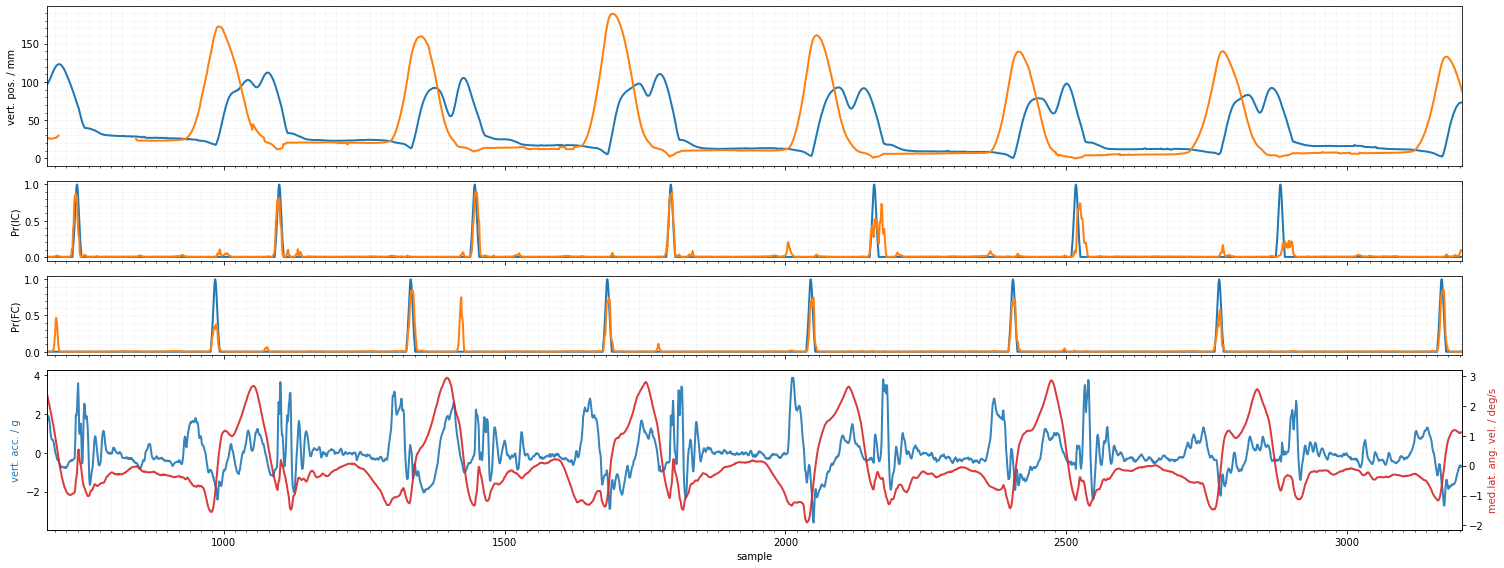

In [60]:
# ix_instance = np.random.choice(len(ds_test), size=1, replace=False)[0]
ix_instance = 265
print(f"{ds_test[ix_instance]['filename_prefix']:s} ... {ds_test[ix_instance]['tracked_point']:s}")
predictions = model.predict(np.expand_dims(ds_test[ix_instance]["data"], axis=0))
plot_predictions(
    path=ROOT_DIR,
    data=ds_test[ix_instance]["data"],
    targets=ds_test[ix_instance]["targets"],
    predictions=predictions,
    filename_prefix=ds_test[ix_instance]["filename_prefix"],
    tracked_point=ds_test[ix_instance]["tracked_point"]
)

In [65]:
ipks, _ = find_peaks(ds_test[ix_instance]["predictions"][1][0][:,0], height=0.4, distance=200//4)
print(ipks)

[  16  649  737 1000 1364 1722 2088 2485]


In [66]:
from scipy.signal import peak_prominences
prominences, _, _ = peak_prominences(ds_test[ix_instance]["predictions"][1][0][:,0], ipks)
print(prominences)

[0.46773145 0.84944366 0.75161557 0.74530141 0.7473419  0.74047205
 0.57532846 0.85591325]
